<a href="https://colab.research.google.com/github/hyuntaedo/Data_Analysis/blob/main/Parking_Data_Anlysis_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 랜덤포레스트(RandomForest)
 - 

In [ ]:
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from tqdm import tqdm

##1. EDA(탐색적 자료분석)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/test.csv')
age_gender_info = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/age_gender_info.csv')
submission = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/sample_submission.csv')

In [ ]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수'],
      dtype='object')

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
train.tail()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2951,C2532,239,아파트,강원도,국민임대,54.95,19,7.0,A,14830000,151030,0.0,1.0,166.0,146.0


- 단지 코드 : 코드
- 총 세대수 : 세대 수
- 임대건물 구분 : 종류
- 공급유형 : 공급유형
- 지역 : 단지 지역
- 자격 유형 : 자격이 있는지 없는지
- 임대보증금 : 보증금 
- 임대료 : 집값
- 도보 10분 거리 내 버정 수 : 버스정류장 수(역세권)
- 등록 차량수 : 주차장 차량 수

In [ ]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [ ]:
print(train.shape)
print(test.shape)
print(submission.shape)

(2952, 15)
(1022, 14)
(150, 2)


### 결측치 확인

In [ ]:
train.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철역수       211
버스정류장수        4
단지내주차면수       0
등록차량수         0
dtype: int64

In [ ]:
test.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철역수        42
버스정류장수        0
단지내주차면수       0
dtype: int64

### 컬럼명 변경

In [ ]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철',
       '버스', '단지내주차면수', '등록차량수']

In [ ]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역수', '버스정류장수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수'],
      dtype='object')

In [ ]:
test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철',
       '버스', '단지내주차면수']

In [ ]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역수', '버스정류장수', '단지내주차면수'],
      dtype='object')

###지역명 숫자로 매핑

In [ ]:
local_map = {}
for idx,loc in enumerate(train['지역'].unique()):
    local_map[loc] = idx

In [ ]:
train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

In [ ]:
print(train['지역'])
print(train.info())
print('\n')
print(test['지역'])
print(test.info())

0       0
1       0
2       0
3       0
4       0
       ..
2947    5
2948    5
2949    5
2950    5
2951    5
Name: 지역, Length: 2952, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   int64  
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철역수     2741 non-null   float64
 12  버스정류장수    2948 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 346.1+ KB
None


0       3
1 

### 상관계수

In [ ]:
import seaborn as sns

In [ ]:
train.corr()

,총세대수,지역,전용면적,전용면적별세대수,공가수,지하철역수,버스정류장수,단지내주차면수,등록차량수
총세대수,1.000000,0.004931,0.042271,0.098205,0.068192,0.213843,-0.001446,0.501488,0.316703
지역,0.004931,1.000000,0.041974,-0.002582,0.014018,0.016195,-0.109894,0.005079,0.038256
전용면적,0.042271,0.041974,1.000000,-0.035479,-0.089201,-0.013111,-0.007866,0.071260,0.115453
전용면적별세대수,0.098205,-0.002582,-0.035479,1.000000,0.166472,-0.056680,0.047112,0.281989,0.247085
공가수,0.068192,0.014018,-0.089201,0.166472,1.000000,-0.093334,0.043285,0.289819,0.118121
지하철역수,0.213843,0.016195,-0.013111,-0.056680,-0.093334,1.000000,0.098380,-0.055544,-0.108592
버스정류장수,-0.001446,-0.109894,-0.007866,0.047112,0.043285,0.098380,1.000000,0.070696,0.103752
단지내주차면수,0.501488,0.005079,0.071260,0.281989,0.289819,-0.055544,0.070696,1.000000,0.859216
등록차량수,0.316703,0.038256,0.115453,0.247085,0.118121,-0.108592,0.103752,0.859216,1.000000


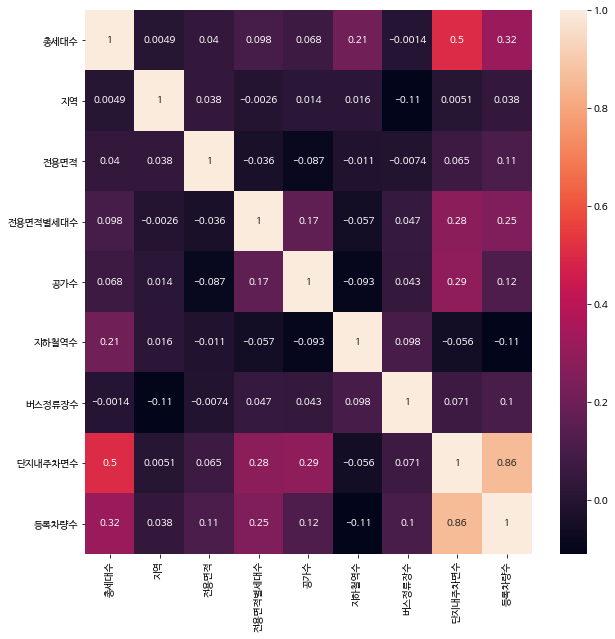

In [ ]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True)

### 전용면적을 5의 배수로 변경

In [ ]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = train['전용면적']//5*5

### 전용면적 상/하한가 적용

In [ ]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [ ]:
train['전용면적'].unique()

array([ 35.,  50.,  55.,  30.,  45.,  40.,  25.,  70.,  15.,  20., 100.,
        60.,  75.,  80.,  65.])

In [ ]:
test['전용면적'].unique()

array([ 35.,  50.,  55.,  30.,  45.,  40.,  25.,  70.,  15.,  20., 100.,
        60.,  75.,  80.])

In [ ]:
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [ ]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [ ]:
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:09, 45.44it/s]
150it [00:03, 44.33it/s]


In [ ]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,276.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,390.0,340.0,362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
419,C2035,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,0.0,180.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
420,C2020,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
421,C2437,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,16.0


In [ ]:
new_train = new_train.fillna(-1)
new_test = new_test.fillna(-1)

In [ ]:
x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

In [ ]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pred = model.predict(x_test)

In [55]:
submission['num'] = pred

In [56]:
submission.to_csv('baseline.csv', index=False)